In [1]:
%load_ext autoreload

In [69]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
from kneed import KneeLocator
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from ld_utils import compute_eigs, get_data_sigma_norms
from multiproc import compute_correlations
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compile_folder, get_data_class, get_result_path, load, run_window_selection, save, to_string

## See if all sessions have finished

In [100]:
all_data_dir = f"/om/user/eisenaj/datasets/anesthesia/mat"
data_class = 'propofolPuffTone'
# all_data_dir = 'leverOddball'

In [101]:
sessions = [filename[:-4] for filename in os.listdir(os.path.join(all_data_dir, data_class)) if filename.endswith('.mat')]

In [102]:
windows = [int(w) if w % 1 == 0 else w for w in np.arange(0.5, 10.5, 0.5)]

In [115]:
bandpass_info = {'flag': False, 'low': 0.5, 'high': 100}

In [116]:
results_dir = os.path.join(f'/om/user/eisenaj/ChaoticConsciousness/results/{data_class}/VAR')
finished_sessions = []
if data_class == 'propofolPuffTone':
    num_areas = 5
elif data_class == 'leverOddball':
    num_areas = 3
for session in tqdm(sessions):
    finished_windows = []
    for window in windows:
        result_path = None
        try:
            result_path = get_result_path(results_dir, session, window, bandpass_info=bandpass_info)
        except Exception as e:
            print(e)
#             tb.print_exception(e)
        if result_path is not None:
            if len(os.listdir(result_path)) != num_areas:
                print(f"Session {session} window {window} only has {os.listdir(result_path)}")
            else:
                missing_areas = []
                for area in os.listdir(result_path):
                    if os.path.isdir(os.path.join(result_path, area)):
                        if len(os.listdir(os.path.join(result_path, area))) == 0:
                            missing_areas.append(area)
                if len(missing_areas) > 0:
                    print(f"Missing session {session} window {window} areas {missing_areas}")
                else:
                    finished_windows.append(window)
        
    if len(finished_windows) == len(windows):
        finished_sessions.append(session)

  0%|          | 0/21 [00:00<?, ?it/s]

In [117]:
finished_sessions

['MrJones-Anesthesia-20160105-01',
 'Mary-Anesthesia-20160818-02',
 'Mary-Anesthesia-20160912-02',
 'Mary-Anesthesia-20160902-02',
 'MrJones-Anesthesia-20160121-01',
 'Mary-Anesthesia-20160809-01',
 'MrJones-Anesthesia-20160113-01',
 'MrJones-Anesthesia-20160109-01',
 'MrJones-Anesthesia-20160210-01',
 'MrJones-Anesthesia-20160123-01',
 'Mary-Anesthesia-20160826-02',
 'MrJones-Anesthesia-20160125-01',
 'MrJones-Anesthesia-20160301-01',
 'MrJones-Anesthesia-20160201-01',
 'MrJones-Anesthesia-20160107-01',
 'Mary-Anesthesia-20160914-02',
 'MrJones-Anesthesia-20160206-01',
 'Mary-Anesthesia-20160822-02',
 'Mary-Anesthesia-20160831-02',
 'Mary-Anesthesia-20160908-02',
 'Mary-Anesthesia-20160916-02']

# Run Window Selection

In [106]:
pred_steps = 10
pct_of_value = 0.95

In [118]:
finished_sessions = ['MrJones-Anesthesia-20160105-01']

In [119]:
VAR_results, window_selection_info = {}, {}
for session in finished_sessions:
    print("="*20)
    print(f"SESSION = {session}")
    print("-"*20)
    VAR_results[session], window_selection_info[session] = run_window_selection(session, bandpass_info=bandpass_info, pred_steps=pred_steps, pct_of_value=pct_of_value)

SESSION = MrJones-Anesthesia-20160105-01
--------------------
Session MrJones-Anesthesia-20160105-01: selected windows by phase with 10-step prediction not found. Running now.
Loading data ...
Data loaded (took 203.72 seconds)
Now computing window = 0.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/24888 [00:00<?, ?it/s]

  0%|          | 0/24888 [00:00<?, ?it/s]

  0%|          | 0/24888 [00:00<?, ?it/s]

  0%|          | 0/24888 [00:00<?, ?it/s]

  0%|          | 0/24888 [00:00<?, ?it/s]

Now computing window = 1


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/12443 [00:00<?, ?it/s]

  0%|          | 0/12443 [00:00<?, ?it/s]

  0%|          | 0/12443 [00:00<?, ?it/s]

  0%|          | 0/12443 [00:00<?, ?it/s]

  0%|          | 0/12443 [00:00<?, ?it/s]

Now computing window = 1.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/8295 [00:00<?, ?it/s]

  0%|          | 0/8295 [00:00<?, ?it/s]

  0%|          | 0/8295 [00:00<?, ?it/s]

  0%|          | 0/8295 [00:00<?, ?it/s]

  0%|          | 0/8295 [00:00<?, ?it/s]

Now computing window = 2


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/6221 [00:00<?, ?it/s]

  0%|          | 0/6221 [00:00<?, ?it/s]

  0%|          | 0/6221 [00:00<?, ?it/s]

  0%|          | 0/6221 [00:00<?, ?it/s]

  0%|          | 0/6221 [00:00<?, ?it/s]

Now computing window = 2.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4976 [00:00<?, ?it/s]

  0%|          | 0/4976 [00:00<?, ?it/s]

  0%|          | 0/4976 [00:00<?, ?it/s]

  0%|          | 0/4976 [00:00<?, ?it/s]

  0%|          | 0/4976 [00:00<?, ?it/s]

Now computing window = 3


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

  0%|          | 0/4147 [00:00<?, ?it/s]

Now computing window = 3.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3554 [00:00<?, ?it/s]

  0%|          | 0/3554 [00:00<?, ?it/s]

  0%|          | 0/3554 [00:00<?, ?it/s]

  0%|          | 0/3554 [00:00<?, ?it/s]

  0%|          | 0/3554 [00:00<?, ?it/s]

Now computing window = 4


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3110 [00:00<?, ?it/s]

  0%|          | 0/3110 [00:00<?, ?it/s]

  0%|          | 0/3110 [00:00<?, ?it/s]

  0%|          | 0/3110 [00:00<?, ?it/s]

  0%|          | 0/3110 [00:00<?, ?it/s]

Now computing window = 4.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

  0%|          | 0/2764 [00:00<?, ?it/s]

Now computing window = 5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2487 [00:00<?, ?it/s]

  0%|          | 0/2487 [00:00<?, ?it/s]

  0%|          | 0/2487 [00:00<?, ?it/s]

  0%|          | 0/2487 [00:00<?, ?it/s]

  0%|          | 0/2487 [00:00<?, ?it/s]

Now computing window = 5.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2261 [00:00<?, ?it/s]

  0%|          | 0/2261 [00:00<?, ?it/s]

  0%|          | 0/2261 [00:00<?, ?it/s]

  0%|          | 0/2261 [00:00<?, ?it/s]

  0%|          | 0/2261 [00:00<?, ?it/s]

Now computing window = 6


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/2073 [00:00<?, ?it/s]

  0%|          | 0/2073 [00:00<?, ?it/s]

  0%|          | 0/2073 [00:00<?, ?it/s]

  0%|          | 0/2073 [00:00<?, ?it/s]

  0%|          | 0/2073 [00:00<?, ?it/s]

Now computing window = 6.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

  0%|          | 0/1913 [00:00<?, ?it/s]

Now computing window = 7


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1776 [00:00<?, ?it/s]

  0%|          | 0/1776 [00:00<?, ?it/s]

  0%|          | 0/1776 [00:00<?, ?it/s]

  0%|          | 0/1776 [00:00<?, ?it/s]

  0%|          | 0/1776 [00:00<?, ?it/s]

Now computing window = 7.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1658 [00:00<?, ?it/s]

  0%|          | 0/1658 [00:00<?, ?it/s]

  0%|          | 0/1658 [00:00<?, ?it/s]

  0%|          | 0/1658 [00:00<?, ?it/s]

  0%|          | 0/1658 [00:00<?, ?it/s]

Now computing window = 8


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1554 [00:00<?, ?it/s]

  0%|          | 0/1554 [00:00<?, ?it/s]

  0%|          | 0/1554 [00:00<?, ?it/s]

  0%|          | 0/1554 [00:00<?, ?it/s]

  0%|          | 0/1554 [00:00<?, ?it/s]

Now computing window = 8.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1463 [00:00<?, ?it/s]

  0%|          | 0/1463 [00:00<?, ?it/s]

  0%|          | 0/1463 [00:00<?, ?it/s]

  0%|          | 0/1463 [00:00<?, ?it/s]

  0%|          | 0/1463 [00:00<?, ?it/s]

Now computing window = 9


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1381 [00:00<?, ?it/s]

  0%|          | 0/1381 [00:00<?, ?it/s]

  0%|          | 0/1381 [00:00<?, ?it/s]

  0%|          | 0/1381 [00:00<?, ?it/s]

  0%|          | 0/1381 [00:00<?, ?it/s]

Now computing window = 9.5


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1308 [00:00<?, ?it/s]

  0%|          | 0/1308 [00:00<?, ?it/s]

  0%|          | 0/1308 [00:00<?, ?it/s]

  0%|          | 0/1308 [00:00<?, ?it/s]

  0%|          | 0/1308 [00:00<?, ?it/s]

Now computing window = 10


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/1243 [00:00<?, ?it/s]

  0%|          | 0/1243 [00:00<?, ?it/s]

Now attempting to load area 7b with window 4
Now attempting to load area CPB with window 4
Now attempting to load area CPB with window 3.5
Now attempting to load area vlPFC with window 3.5
Now attempting to load area FEF with window 3
Now attempting to load area vlPFC with window 4.5
Now attempting to load area 7b with window 7
Now attempting to load area all with window 7
Now attempting to load area vlPFC with window 7
Now attempting to load area CPB with window 7.5
Now attempting to load area all with window 7.5
Now attempting to load area 7b with window 5
Now attempting to load area FEF with window 5
Now attempting to load area all with window 8.5
Now attempting to load area FEF with window 10


# Plot

In [108]:
# session = 'SPOCK_Ketamine_20210909'
session = finished_sessions[0]

In [109]:
window_selection_info[session]['selected_windows']

{'pre': {'7b': 8.5, 'CPB': 9.5, 'FEF': 9, 'vlPFC': 7, 'all': 9},
 'during': {'7b': 9, 'CPB': 10, 'FEF': 10, 'vlPFC': 8.5, 'all': 10},
 'post': {'7b': 8, 'CPB': 10, 'FEF': 9, 'vlPFC': 10, 'all': 9}}

In [110]:
area = 'vlPFC'
anesthesia_start_ind = np.argmax(VAR_results[session][area]['start_time'] > session_info['drugStart'][0])
LOC_ind = np.argmax(VAR_results[session][area]['start_time'] > session_info['eyesClose'])
anesthesia_end_ind = np.argmax(VAR_results[session][area]['start_time'] > session_info['drugEnd'][1])

In [111]:
# wake_inds = np.hstack(VAR_results[session][area][:anesthesia_start_ind].criticality_inds.to_numpy())
# anesthesia_inds = np.hstack(VAR_results[session][area][LOC_ind:anesthesia_end_ind].criticality_inds.to_numpy())
wake_inds = np.hstack(VAR_results[session][area][:anesthesia_start_ind].criticality_inds.apply(lambda x: x.mean()).to_numpy())
anesthesia_inds = np.hstack(VAR_results[session][area][LOC_ind:anesthesia_end_ind].criticality_inds.apply(lambda x: x.mean()).to_numpy())

In [112]:
def t_test_1_side(vals_1, vals_2):
    # t-test
    n1 = len(vals_1)
    n2 = len(vals_2)
    print(n1, n2)
    mean_1 = vals_1.mean()
    mean_2 = vals_2.mean()
    var_1 = ((vals_1 - vals_1.mean())**2).sum()/(n1 - 1)
    var_2 = ((vals_2 - vals_2.mean())**2).sum()/(n2 - 1)
    s_squared = (n1 - 1)/(n1 + n2 - 2)*var_1 + (n2 - 1)/(n1 + n2 - 2)*var_2
    t_stat = (mean_1 - mean_2)/(np.sqrt(s_squared)*np.sqrt((1/n1) + (1/n2)))
    p = 2*scipy.stats.t.sf(t_stat, df=n1 + n2 - 2)
    print(t_stat)
    print(scipy.stats.t.sf(t_stat, df=n1 + n2 - 2))
    
    return p

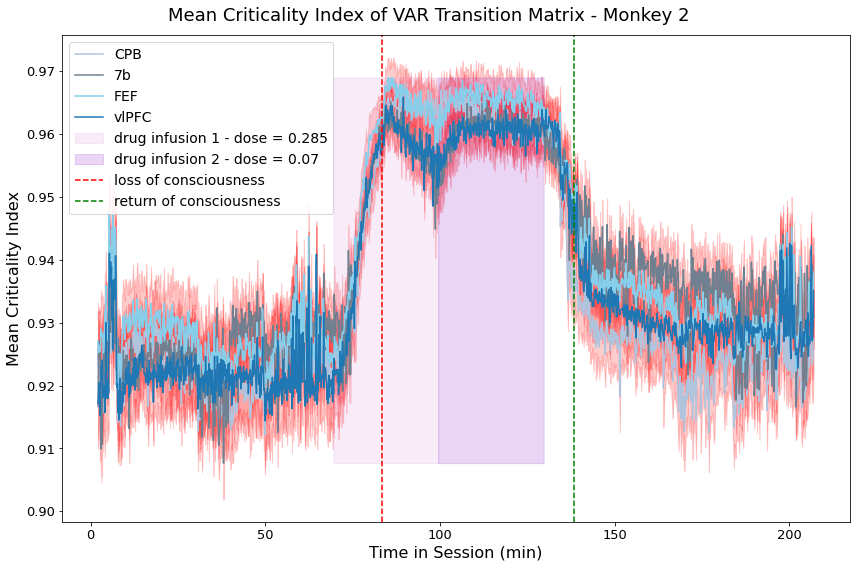

In [113]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
session_info = loadmat(filename, variables=['sessionInfo'], verbose=False)
plot_individual_areas(session, data_class, VAR_results[session], session_info, start_time=125, end_time=None)

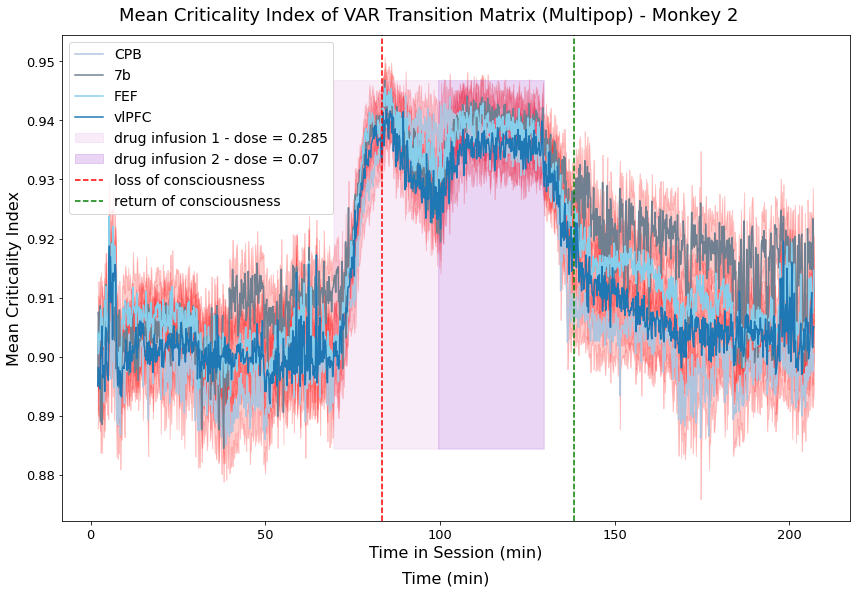

In [114]:
electrode_info = loadmat(filename, variables=['electrodeInfo'], verbose=False)
plot_multipopulation(session, data_class, VAR_results[session], session_info, electrode_info, start_time=125, end_time=None)

In [90]:
VAR_results_2, window_selection_info_2 = run_window_selection(session, bandpass_info=None, pred_steps=pred_steps, pct_of_value=pct_of_value)

VAR results with selected windows found for session MrJones-Anesthesia-20160105-01.
Window selection info found for session MrJones-Anesthesia-20160105-01.


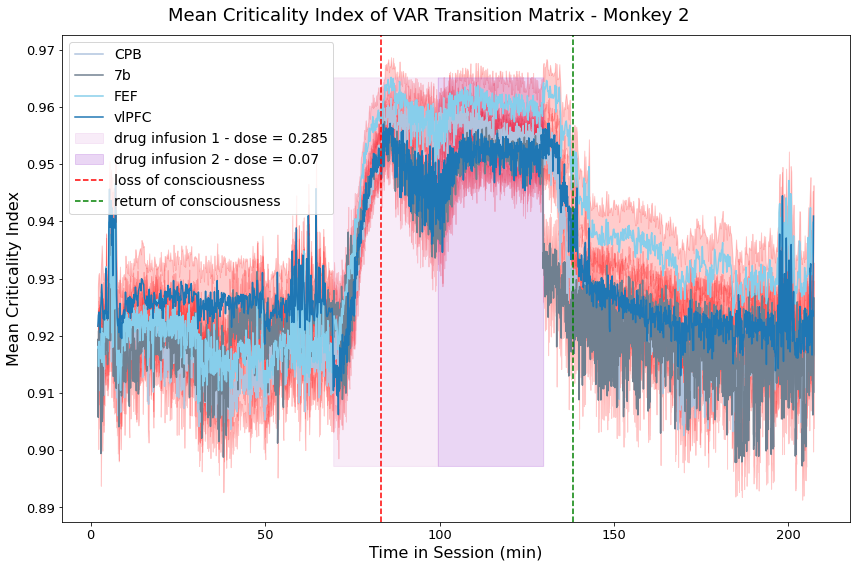

In [91]:
filename = os.path.join(all_data_dir, data_class, f'{session}.mat')
session_info = loadmat(filename, variables=['sessionInfo'], verbose=False)
plot_individual_areas(session, data_class, VAR_results_2, session_info, start_time=125, end_time=None)

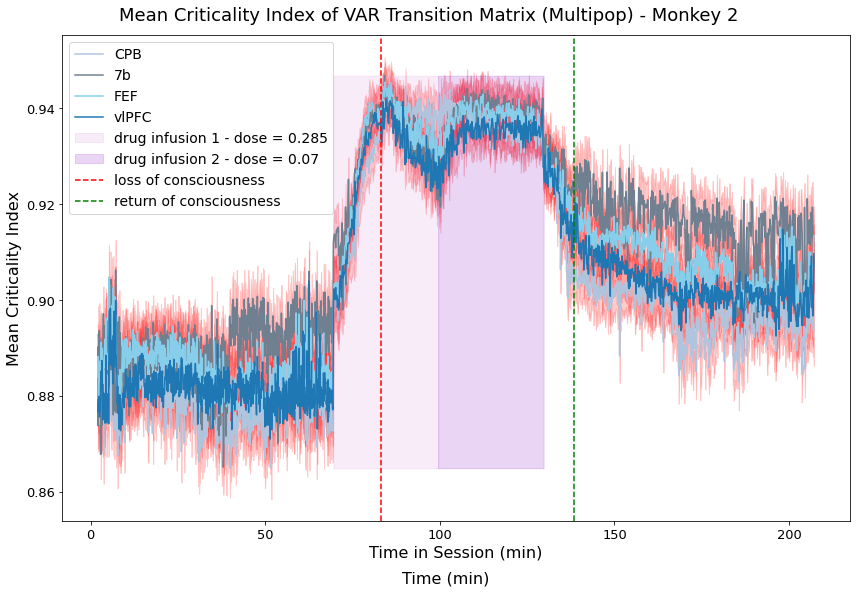

In [92]:
electrode_info = loadmat(filename, variables=['electrodeInfo'], verbose=False)
plot_multipopulation(session, data_class, VAR_results_2, session_info, electrode_info, start_time=125, end_time=None)